<a href="https://colab.research.google.com/github/drAshcroft/MAT422/blob/main/HW_4_2_Spectral_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# import libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt
import networkx as nx
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch


Spectral clustering is used when the relationship between datapoints is known, but the positions of the data in some absolute system is not known.  The data is translated into a laplacian matrix and then solved to create clusters

In this case we usethe CIRFAR10 database which contains images of data clustered into 10 categories.

Files already downloaded and verified


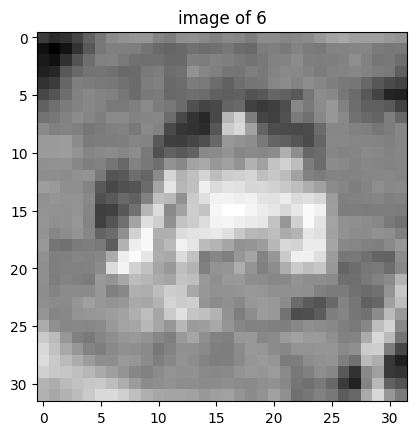

In [ ]:
# Load the MNIST dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())



# Display the image
plt.title(f'image of {train_dataset[0][1]}')
plt.imshow(train_dataset[0][0][0], cmap='gray')
plt.show()


We then use the convolution function to map the similarities between images.  Convolution is useful for this case as it is less sensitive to color and location of objects, but is good for determining the similarity of shapes.

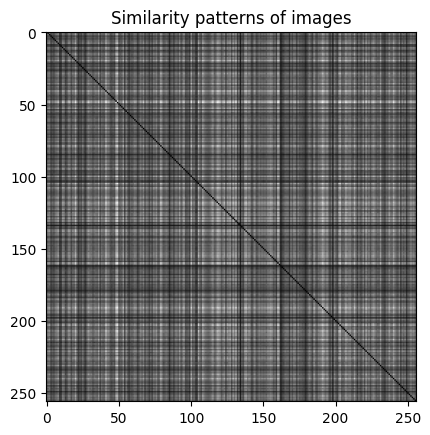

In [ ]:
adjacency = np.zeros((256,256))
for i in range(256):
  for j in range(i+1,256):
    vR=scipy.signal.fftconvolve (train_dataset[i][0][0],train_dataset[j][0][0])
    vB=scipy.signal.fftconvolve (train_dataset[i][0][1],train_dataset[j][0][1])
    vG=scipy.signal.fftconvolve (train_dataset[i][0][2],train_dataset[j][0][2])
    ac = np.max(vR+vB+vG)
    adjacency[i][j]=ac
    adjacency[j][i]=ac

# Display the image
plt.title(f'Similarity patterns of images')
plt.imshow(adjacency, cmap='gray')
plt.show()

Load the needed libraries.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn import metrics
import random

We now take this information and use it to create a symmetric lapacian matrix to get eigenvectors of the different paths.

The more similar the eigenvector, the more likely the nodes are to being close in state space.

In [ ]:
#create a symmetrically normalized adjacency matrix
def laplacianNorm(A):
  degree = np.diag(A.sum(axis=0)**(-0.5))
  return degree.dot(A).dot(degree)


def spectral_clustering(affinity, n_clusters ):
  #change matrix to symetric form for calculation of matrix
  L = laplacianNorm(affinity)
  #find eigenvectors for the larger values
  eig_val, eig_vect = scipy.sparse.linalg.eigs(L, n_clusters)
  eig_val=eig_val.real
  X = eig_vect.real
  ind = np.argsort(eig_val)
  eig_val = eig_val[ind]
  X = X[:, ind[:n_clusters]]
  #normalize the values to help deal with small numbers
  rows_norm = np.linalg.norm(X, axis=1, ord=2)
  Y = (X.T / rows_norm).T
  #create a kmeans solver
  kmeans = KMeans(n_clusters=n_clusters , random_state=42)
  #fit the data and return labels
  return kmeans.fit(X).labels_

n_clusters_= 8
labels = spectral_clustering(adjacency,n_clusters=n_clusters_)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


We can now plot out examples of the clustering to determine utiliity of our similarity metric

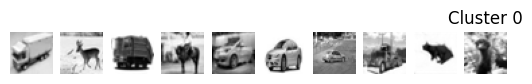

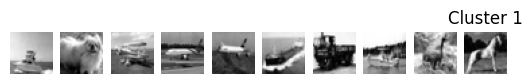

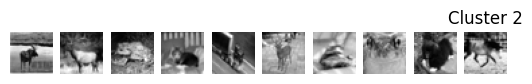

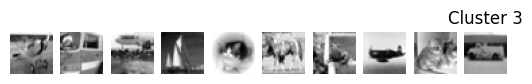

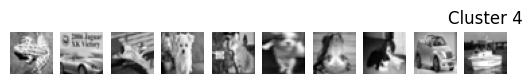

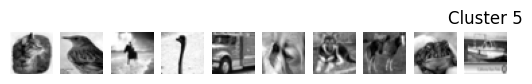

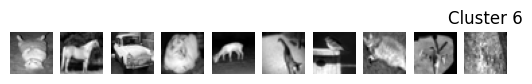

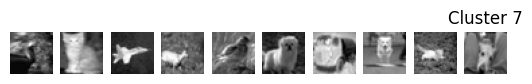

In [ ]:


for k in range( n_clusters_ ):
    #select items predicted from laels
    my_members = np.argwhere (labels == k).ravel().tolist()
    #select a random 10 items
    my_members = random.sample(my_members,np.min([10,len(my_members)]))
    cc=0
    fig,ax= plt.subplots(1,10)
    plt.title(f'Cluster {k}')
    for i in my_members:
        ax[cc].imshow(train_dataset[i][0][0], cmap='gray')
        ax[cc].axis('off')
        cc+=1
    plt.show()


plt.show()

We can see that while the procedure did a good job with finding similar images, it did not work well for clustering by the content of the images.  

This is a common problem with image data, as very small differences explain the differene between a dog and a cat.